# AIPI 590 - XAI | Assignment #05
### Explainable Deep Learning
### Ayush Gupta


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/templates/template.ipynb)

### Hypothesis



```
H0 = "The ResNet50 model does not significantly differentiate between shape-based and texture-based features in classification."

H1 = "The ResNet50 model significantly relies more on texture-based features compared to shape-based features in classification."

```



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


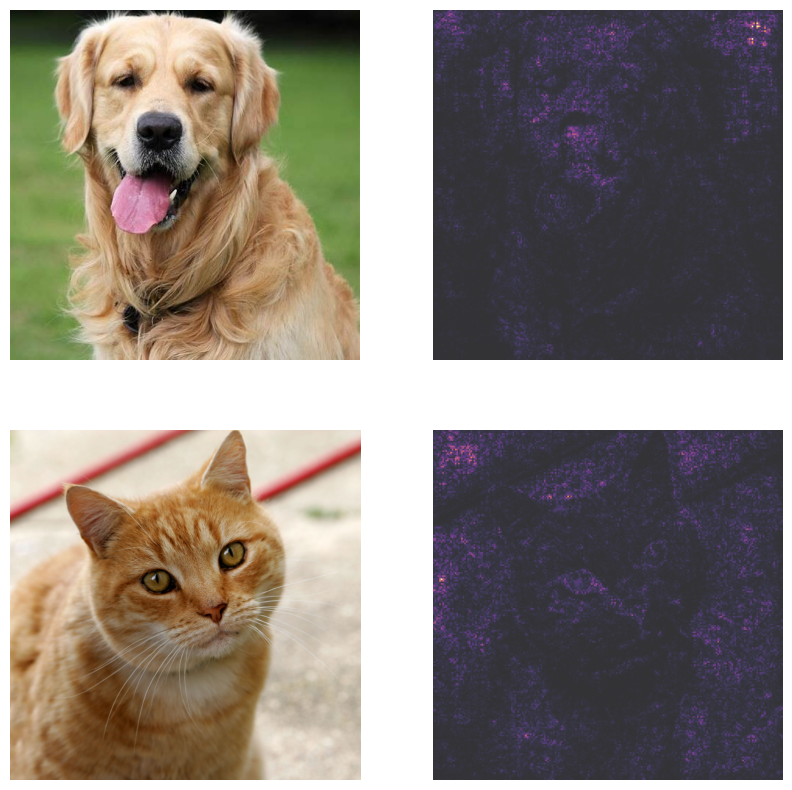

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, UnidentifiedImageError
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True).to(device)
model.eval()

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


image_urls = [
    "https://tse3.mm.bing.net/th?id=OIP.9jp3vrVA5qHN5WLPI6ebQAHaLH&w=474&h=474&c=7",
    "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg",
]

attribution_maps = []
for image_url in image_urls:
    try:
        response = requests.get(image_url, timeout=5)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB")
    except (requests.RequestException, UnidentifiedImageError):
        print(f"Failed to load image from {image_url}, using a fallback image.")
        image = Image.new("RGB", (224, 224), color="gray")

    input_tensor = transform(image).unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    ig = IntegratedGradients(model)
    pred_label_idx = model(input_tensor).argmax(dim=1).item()
    attributions = ig.attribute(input_tensor, target=pred_label_idx, n_steps=50)
    attributions = attributions.squeeze().detach().cpu().numpy()

    attributions = np.abs(attributions).sum(
        axis=0
    )  # Enhance visibility by summing across channels
    attributions = (attributions - np.min(attributions)) / (
        np.max(attributions) - np.min(attributions) + 1e-10
    )
    attribution_maps.append((image, attributions))


def visualize_attributions(attribution_maps):
    fig, axes = plt.subplots(
        len(attribution_maps), 2, figsize=(10, 5 * len(attribution_maps))
    )
    for i, (original_image, attributions) in enumerate(attribution_maps):
        axes[i, 0].imshow(original_image)
        axes[i, 0].axis("off")
        axes[i, 1].imshow(attributions, cmap="inferno", alpha=0.8)
        axes[i, 1].axis("off")
    plt.show()


visualize_attributions(attribution_maps)

#### Interpreting the Attribution Maps

#### If the model were focusing on shape, we would expect:

Strong attributions along the outlines of the objects (dog’s body, cat’s face, etc.).

Distinct edges being highlighted where the model is making decisions based on the overall structure.

#### What we actually see:

The attribution maps are diffuse and highlight fine-grained details rather than the object boundaries.

The activations are spread across textures like fur, facial regions, and patterns rather than following a structured outline.

The cat’s face has random speckles of attributions rather than being sharply outlined.


Based on the attributions, we observe that the model focuses more on texture-based information rather than global shape structures in classification. This suggests that our null hypothesis H0 can be rejected in favor of H1, indicating a significant reliance on texture cues over shape-based features. Source: code generated by ChatGPT, analysis done by visualizaiton.  
